<a href="https://colab.research.google.com/github/maricari/NLP/blob/main/4e_predicci%C3%B3n_palabra_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import pad_sequences

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [ ]:
# Para plotear
import matplotlib.pyplot as plt
import seaborn as sns

### Datos
Utilizaremos como dataset el libro *I. Origen de los indios de América.* disponible en www.gutemberg.org

In [2]:
# Para leer y parsear el texto en HTML
import urllib.request
import bs4 as bs

# Para limpiar el texto
import re

In [ ]:
raw_html = urllib.request.urlopen('https://www.gutenberg.org/cache/epub/56219/pg56219-images.html')
raw_html = raw_html.read()

# Parsea el artículo
article_html = bs.BeautifulSoup(raw_html, 'lxml')
article_paragraphs = article_html.find_all('p')

article_text = list()
flag = 0 # para quedarse únicamente la parte I del libro
for para in article_paragraphs:
  text = (re.sub(r'\s+', ' ', para.text)).replace('\'','')
  text = re.sub(r'\[[0-9]+\]', '', text)
  if text == '':
    continue
  if flag:
    article_text.append(text)
  else:
    if 'grandes y heróicas civilizaciones indianas de esas mismas épocas' in text:
      flag = 1
  if 'FIN DE LA PRIMERA PARTE' in text:
    break
article_text


In [51]:
len(article_text)

1213

In [169]:
# muestra del texto
article_text[1080:1090]

['Rabihorcado, ave grande de rapiña cuyas alas desplegadas ocupan el espacio de catorce pies, y es de mucho vuelo, pues apesar de ser terrestre, extiende su vuelo hasta treinta leguas y más, dentro del mar.',
 'Rabo de junco, ave terrestre muy grande, que tiene la cola larga y muy delgada, que también vuela en el mar á grandes distancias.',
 'Sinsonte, ave de canto tan armonioso que se le considera como el rey de las aves, por su canto y trinos que embelezan.',
 'Tángara, especie de gorrión, propio de los países equinocciales de América.',
 'Tucán, especie de picazo; es ave propia del Brasil.',
 'Tinamón, gallinacea, exclusivamente propia de la América Meridional.',
 'Turpian, cuyo canto es muy agradable y entretenido.',
 'Toro-Pisco, de lindo color, con un moño en forma de plumero.',
 'Trompetero, que tiene la particularidad de cantar por el ano.',
 'Tijeras-Chupa, cuya cola está en forma de tijeras.']

### 1 - Ejemplo de Preprocesamiento

In [62]:
# texto de muestra
text = article_text[1084]
text

'Tucán, especie de picazo; es ave propia del Brasil.'

In [63]:
# Transformar las oraciones en tokens
tokens = text_to_word_sequence(text)
tokens

['tucán', 'especie', 'de', 'picazo', 'es', 'ave', 'propia', 'del', 'brasil']

In [64]:
# Desfazaje de las palabras según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)
text_sequences

[['tucán', 'especie', 'de', 'picazo'],
 ['especie', 'de', 'picazo', 'es'],
 ['de', 'picazo', 'es', 'ave'],
 ['picazo', 'es', 'ave', 'propia'],
 ['es', 'ave', 'propia', 'del']]

In [65]:
tok = Tokenizer() 

# Creates the vocabulary index based on word frequency.
tok.fit_on_texts(text_sequences)

# Transforms each text to a sequence of integers
sequences = tok.texts_to_sequences(text_sequences)
sequences

[[7, 5, 3, 1], [5, 3, 1, 2], [3, 1, 2, 4], [1, 2, 4, 6], [2, 4, 6, 8]]

In [66]:
print(tok.document_count)

5


In [67]:
tok.word_counts

OrderedDict([('tucán', 1),
             ('especie', 2),
             ('de', 3),
             ('picazo', 4),
             ('es', 4),
             ('ave', 3),
             ('propia', 2),
             ('del', 1)])

In [68]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'picazo': 1, 'es': 2, 'de': 3, 'ave': 4, 'especie': 5, 'propia': 6, 'tucán': 7, 'del': 8}


### 2 - Preprocesamiento completo

In [69]:
# Recorre todas las filas y transforma las oraciones
# en secuencias de palabras
sentence_tokens = []
for i in range(len(article_text)):
    sentence_tokens.append(text_to_word_sequence(article_text[i]))

In [70]:
sentence_tokens[1084]

['tucán', 'especie', 'de', 'picazo', 'es', 'ave', 'propia', 'del', 'brasil']

In [ ]:
# Concatena todos los rows en un corpus
df = pd.DataFrame(article_text)
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

In [171]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
tokens[:20]

['antes',
 'de',
 'abordar',
 'el',
 'asunto',
 'del',
 'presente',
 'trabajo',
 'debemos',
 'indicar',
 'de',
 'preferencia',
 'cuáles',
 'fueron',
 'los',
 'habitantes',
 'del',
 'continente',
 'de',
 'américa']

In [73]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 51728


In [74]:
# Desfazaje de las palabras según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [78]:
text_sequences[:10]

[['antes', 'de', 'abordar', 'el'],
 ['de', 'abordar', 'el', 'asunto'],
 ['abordar', 'el', 'asunto', 'del'],
 ['el', 'asunto', 'del', 'presente'],
 ['asunto', 'del', 'presente', 'trabajo'],
 ['del', 'presente', 'trabajo', 'debemos'],
 ['presente', 'trabajo', 'debemos', 'indicar'],
 ['trabajo', 'debemos', 'indicar', 'de'],
 ['debemos', 'indicar', 'de', 'preferencia'],
 ['indicar', 'de', 'preferencia', 'cuáles']]

In [80]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 
sequences = tok.texts_to_sequences(text_sequences)
sequences[:10]

[[69, 1, 9374, 7],
 [1, 9374, 7, 1012],
 [9374, 7, 1012, 8],
 [7, 1012, 8, 1595],
 [1012, 8, 1595, 2231],
 [8, 1595, 2231, 1013],
 [1595, 2231, 1013, 1232],
 [2231, 1013, 1232, 1],
 [1013, 1232, 1, 3602],
 [1232, 1, 3602, 2232]]

### 3 - Input y target

In [81]:
# Separar las palabras objetivos (target) que el modelo debe predecir.
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1]

print(x_data.shape)
print(y_data_int.shape)

(51724, 3)
(51724,)


In [83]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'y',
 4: 'que',
 5: 'en',
 6: 'los',
 7: 'el',
 8: 'del',
 9: 'las',
 10: 'á',
 11: 'se',
 12: 'por',
 13: 'es',
 14: 'su',
 15: 'ó',
 16: 'con',
 17: 'américa',
 18: 'una',
 19: 'para',
 20: 'un',
 21: 'al',
 22: 'más',
 23: 'como',
 24: 'sus',
 25: 'no',
 26: 'muy',
 27: 'también',
 28: 'lo',
 29: 'otros',
 30: 'entre',
 31: 'este',
 32: 'color',
 33: 'continente',
 34: 'perú',
 35: 'pues',
 36: 'son',
 37: 'hasta',
 38: 'especie',
 39: 'cuya',
 40: 'planta',
 41: 'algunos',
 42: 'méxico',
 43: 'río',
 44: 'indios',
 45: 'tan',
 46: 'han',
 47: 'isla',
 48: 'años',
 49: 'desde',
 50: 'mundo',
 51: 'sobre',
 52: 'ha',
 53: 'árbol',
 54: 'fueron',
 55: 'fué',
 56: 'hay',
 57: 'parte',
 58: 'otras',
 59: 'tierra',
 60: 'autores',
 61: 'después',
 62: 'gran',
 63: 'donde',
 64: 'contra',
 65: 'cuyas',
 66: 'nuevo',
 67: 'esta',
 68: 'americano',
 69: 'antes',
 70: 'dos',
 71: 'raza',
 72: 'islas',
 73: 'época',
 74: 'mismo',
 75: 'piedra',
 76: 'tiene',
 77: 'cuyo

In [84]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

9374

In [85]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(51724, 9374)

### 4 - Entrenar el modelo

In [86]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [87]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

9374

In [88]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 9374 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 9374 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              46875     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 9374)              309342    
                                                                 
Total params: 409,241
Trainable params: 409,241
Non-trai

In [138]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
1294/1294 [==============================] - 13s 10ms/step - loss: 3.1786 - accuracy: 0.3053 - val_loss: 18.7112 - val_accuracy: 0.0767
Epoch 2/100
1294/1294 [==============================] - 11s 9ms/step - loss: 3.1642 - accuracy: 0.3089 - val_loss: 18.6836 - val_accuracy: 0.0787
Epoch 3/100
1294/1294 [==============================] - 12s 10ms/step - loss: 3.1445 - accuracy: 0.3106 - val_loss: 18.9899 - val_accuracy: 0.0780
Epoch 4/100
1294/1294 [==============================] - 11s 9ms/step - loss: 3.1317 - accuracy: 0.3133 - val_loss: 18.9436 - val_accuracy: 0.0801
Epoch 5/100
1294/1294 [==============================] - 11s 9ms/step - loss: 3.1058 - accuracy: 0.3167 - val_loss: 19.1860 - val_accuracy: 0.0812
Epoch 6/100
1294/1294 [==============================] - 11s 9ms/step - loss: 3.0945 - accuracy: 0.3197 - val_loss: 19.6004 - val_accuracy: 0.0800
Epoch 7/100
1294/1294 [==============================] - 12s 9ms/step - loss: 3.0792 - accuracy: 0.3200 - val_loss: 

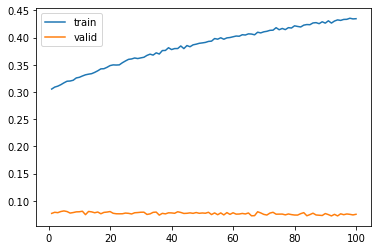

In [140]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

Construimos un segundo modelo similar al anterior, pero con más capas intermedias. También subimos el dropout a 0.5 (el valor por defecto) 

In [174]:
model2 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 9374 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model2.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model2.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 9374 palabras posibles
model2.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 5)              46875     
                                                                 
 lstm_5 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_3 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_6 (LSTM)               (None, 3, 64)             33024     
                                                                 
 dropout_4 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 3, 64)             33024     
                                                                 
 dropout_5 (Dropout)         (None, 3, 64)            

In [175]:
hist2 = model2.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
1294/1294 [==============================] - 27s 17ms/step - loss: 7.1311 - accuracy: 0.0781 - val_loss: 7.3052 - val_accuracy: 0.0814
Epoch 2/100
1294/1294 [==============================] - 18s 14ms/step - loss: 6.7291 - accuracy: 0.0782 - val_loss: 7.5216 - val_accuracy: 0.0814
Epoch 3/100
1294/1294 [==============================] - 18s 14ms/step - loss: 6.6677 - accuracy: 0.0782 - val_loss: 7.6374 - val_accuracy: 0.0814
Epoch 4/100
1294/1294 [==============================] - 20s 15ms/step - loss: 6.6346 - accuracy: 0.0782 - val_loss: 7.8462 - val_accuracy: 0.0814
Epoch 5/100
1294/1294 [==============================] - 16s 13ms/step - loss: 6.5771 - accuracy: 0.0783 - val_loss: 7.9802 - val_accuracy: 0.0800
Epoch 6/100
1294/1294 [==============================] - 16s 13ms/step - loss: 6.5131 - accuracy: 0.0783 - val_loss: 8.0905 - val_accuracy: 0.0797
Epoch 7/100
1294/1294 [==============================] - 21s 16ms/step - loss: 6.4317 - accuracy: 0.0784 - val_loss: 8

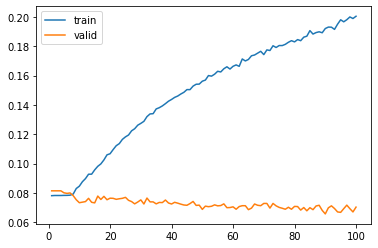

In [176]:
# Entrenamiento modelo 2
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

## Primeras conclusiones
- Ninguno de los dos modelos mostró buenos resultados. En ambos casos hay overfitting.
- En train, 100 epochs mostraron una mejor accuracy que los 50 con los que se había entrenado originalmente, pero aún así es la métrica es bastante baja.


### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

# Ajustar la secuencia de entrada al tamaño fijo (3).
# Si supera el tamaño, se trunca
# Si es más corta, se agrega un prefijo con ceros

In [142]:
# Recibe un texto y un modelo y retorna la predicción
def model_response(human_text, m):

    # encoding
    encoded = tok.texts_to_sequences([human_text])[0]
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # predicción softmax
    y_hat = m.predict(encoded).argmax(axis=-1)

    # palabra que corresponde al indice (y_hat) predicho por el modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # frase predicha + predicción
    return human_text + ' ' + out_word


In [177]:
# probamos la función de predicción con un texto de ejemplo 
model_response('Santo Domingo', model)

1/1 [==============================] - 0s 17ms/step


'Santo Domingo más'

In [192]:
model_response('trataban a los indios como si fueran ', model)

1/1 [==============================] - 0s 19ms/step


'trataban a los indios como si fueran  fundándose'

Probamos con algunos textos de ejemplo para ver las respuestas con ambos modelos.

In [194]:
input = ['los conquistadores del río', 'aztecas, mayas, griegos,', 'trataban a los indios como si fueran',
         'Santo Domingo', 'fueron explorados como', 'no tuvieron', 'sus bosques tupidos', 'provincia de San Juan y',
         'árbol cuya madera es','sus grandes hojas']
for _,input_text in enumerate(input):
  output = model_response(input_text, model)
  output2 = model_response(input_text, model2)
  print(f"{input_text}\n M1 >>>{output}\n M2 >>>{output2}")

1/1 [==============================] - 0s 18ms/step
los conquistadores del río
 M1 >>>los conquistadores del río parálisis
 M2 >>>los conquistadores del río cabildo
1/1 [==============================] - 0s 17ms/step
aztecas, mayas, griegos,
 M1 >>>aztecas, mayas, griegos, piedra
 M2 >>>aztecas, mayas, griegos, ahora
1/1 [==============================] - 0s 18ms/step
trataban a los indios como si fueran
 M1 >>>trataban a los indios como si fueran fundándose
 M2 >>>trataban a los indios como si fueran árboles
1/1 [==============================] - 0s 19ms/step
Santo Domingo
 M1 >>>Santo Domingo más
 M2 >>>Santo Domingo y
1/1 [==============================] - 0s 17ms/step
fueron explorados como
 M1 >>>fueron explorados como en
 M2 >>>fueron explorados como y
1/1 [==============================] - 0s 19ms/step
no tuvieron
 M1 >>>no tuvieron sacrificio
 M2 >>>no tuvieron batalla
1/1 [==============================] - 0s 18ms/step
sus bosques tupidos
 M1 >>>sus bosques tupidos prehistóric

### 6 - Generación de secuencias nuevas

In [153]:
# Modelo autoregresivo
def generate_seq(m, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            m (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text

    for _ in range(n_words):
		    # encoding
        encoded = tokenizer.texts_to_sequences([output_text])[0]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
    		# predicción softmax
        y_hat = m.predict(encoded).argmax(axis=-1)

        # palabra que corresponde al índice (y_hat) predicho por el modelo
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

        # frase predicha + predicción
		    # (se usa como input en la próxima predicción 
        output_text += ' ' + out_word

    return output_text

In [184]:
 # Probamos la función con el mismo texto que antes ... 
generate_seq(model, tok, 'Santo Domingo', max_length=3, n_words=2)

1/1 [==============================] - 0s 16ms/step


'Santo Domingo más cuyos'

Volvemos a probar ambos modelos con la misma secuencia de textos, pero esta vez para predecir dos palabras.

In [195]:
for _,input_text in enumerate(input):
  output = generate_seq(model, tok, input_text, max_length=3, n_words=2)
  output2 = generate_seq(model2, tok, input_text, max_length=3, n_words=2)
  print(f"{input_text}\n M1 >>>{output}\n M2 >>>{output2}")

1/1 [==============================] - 0s 21ms/step
los conquistadores del río
 M1 >>>los conquistadores del río parálisis por
 M2 >>>los conquistadores del río cabildo 
1/1 [==============================] - 0s 17ms/step
aztecas, mayas, griegos,
 M1 >>>aztecas, mayas, griegos, piedra no
 M2 >>>aztecas, mayas, griegos, ahora la
1/1 [==============================] - 0s 19ms/step
trataban a los indios como si fueran
 M1 >>>trataban a los indios como si fueran fundándose reiteradas
 M2 >>>trataban a los indios como si fueran árboles la
1/1 [==============================] - 0s 19ms/step
Santo Domingo
 M1 >>>Santo Domingo más cuyos
 M2 >>>Santo Domingo y de
1/1 [==============================] - 0s 19ms/step
fueron explorados como
 M1 >>>fueron explorados como en y
 M2 >>>fueron explorados como y en
1/1 [==============================] - 0s 18ms/step
no tuvieron
 M1 >>>no tuvieron sacrificio misión
 M2 >>>no tuvieron batalla las
1/1 [==============================] - 0s 19ms/step
sus bosq

## Conclusiones
En base al accuracy, habíamos observado que los resultados de entrenar estos dos modelos no había sido bueno.
Al mirar las predicciones con algunos textos de ejemplo tampoco se ven resultados de interés; algunas predicciones fueron originales (*trataban a los indios como si fueran árboles*), otras sin sentido (*provincia de San Juan y collingast*). En conclusión, no puede decirse que alguno de los dos modelos propuestos sea mejor (o peor) que el otro.

Las pruebas que se realizaron consistieron en empezar con un modelo base y experimentar con más epochs y con más capas. Se podría considerar probar con más neuronas, agregar BRNN, trabajar con un corpus mayor (se intentó pero el Google Colab se quedó sin recursos), probar otro largo de secuencia, o usar embeddings pre-entrenados.